In [82]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")

# Reset if needed below
# warnings.filterwarnings("default")

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

pd.set_option('display.float_format', '{:.2f}'.format)

from matplotlib.ticker import ScalarFormatter

In [43]:
df = pd.read_csv('ppp_risk.csv')
df.head(5)

LoanNumber DateApproved  SBAOfficeCode ProcessingMethod  \
0  9547507704   2020-05-01            464              PPP   
1  9777677704   2020-05-01            464              PPP   
2  5791407702   2020-05-01           1013              PPP   
3  6223567700   2020-05-01            920              PPP   
4  9662437702   2020-05-01            101              PPP   

               BorrowerName        BorrowerAddress       BorrowerCity  \
0     SUMTER COATINGS, INC.  2410 HIGHWAY 15 SOUTH             SUMTER   
1     PLEASANT PLACES, INC.    7684 SOUTHRAIL ROAD   NORTH CHARLESTON   
2   BOYER CHILDREN'S CLINIC       1850 BOYER AVE E            SEATTLE   
3  KIRTLEY CONSTRUCTION INC   1661 MARTIN RANCH RD     SAN BERNARDINO   
4              AERO BOX LLC      UNKNOWN/NOTSTATED  UNKNOWN/NOTSTATED   

       BorrowerState BorrowerZip LoanStatusDate    LoanStatus  Term  \
0  UNKNOWN/NOTSTATED       29150     2020-12-18  PAID IN FULL    24   
1  UNKNOWN/NOTSTATED       29420     2021-09-28  PAID IN FULL    24   
2  UNKNOWN/NOTSTATED       98112     2021-03-17  PAID IN FULL    24   
3  UNKNOWN/NOTSTATED       92407     2021-10-16  PAID IN FULL    24   
4  UNKNOWN/NOTSTATED       UNKNO     2021-08-17  PAID IN FULL    24   

   SBAGuarantyPercentage  InitialApprovalAmount  CurrentApprovalAmount  \
0                    100              769358.78              769358.78   
1                    100              736927.79              736927.79   
2                    100              691355.00              691355.00   
3                    100              499871.00              499871.00   
4                    100              367437.00              367437.00   

   UndisbursedAmount      FranchiseName  ServicingLenderLocationID  \
0               0.00  UNKNOWN/NOTSTATED                      19248   
1               0.00  UNKNOWN/NOTSTATED                      19248   
2               0.00  UNKNOWN/NOTSTATED                       9551   
3               0.00  UNKNOWN/NOTSTATED                       9551   
4               0.00  UNKNOWN/NOTSTATED                      57328   

                     ServicingLenderName   ServicingLenderAddress  \
0                           SYNOVUS BANK            1148 BROADWAY   
1                           SYNOVUS BANK            1148 BROADWAY   
2  BANK OF AMERICA, NATIONAL ASSOCIATION  100 N TRYON ST, STE 170   
3  BANK OF AMERICA, NATIONAL ASSOCIATION  100 N TRYON ST, STE 170   
4           THE HUNTINGTON NATIONAL BANK            17 S HIGH ST.   

  ServicingLenderCity ServicingLenderState  ServicingLenderZip  \
0            COLUMBUS                   GA               31901   
1            COLUMBUS                   GA               31901   
2           CHARLOTTE                   NC               28202   
3           CHARLOTTE                   NC               28202   
4            COLUMBUS                   OH               43215   

  RuralUrbanIndicator HubzoneIndicator LMIIndicator  \
0                   U                N            N   
1                   U                Y            Y   
2                   U                N            N   
3                   U                N            N   
4                   U                N            N   

              BusinessAgeDescription        ProjectCity  ProjectCountyName  \
0  EXISTING OR MORE THAN 2 YEARS OLD             SUMTER             SUMTER   
1  EXISTING OR MORE THAN 2 YEARS OLD   NORTH CHARLESTON         CHARLESTON   
2    NEW BUSINESS OR 2 YEARS OR LESS            SEATTLE               KING   
3    NEW BUSINESS OR 2 YEARS OR LESS     SAN BERNARDINO     SAN BERNARDINO   
4                  UNKNOWN/NOTSTATED  UNKNOWN/NOTSTATED  UNKNOWN/NOTSTATED   

        ProjectState ProjectZip                 CD  JobsReported  NAICSCode  \
0                 SC      29150              SC-05         62.00  325510.00   
1                 SC      29420              SC-06         73.00  561730.00   
2                 WA      98112              WA-0

<AxesSubplot:>

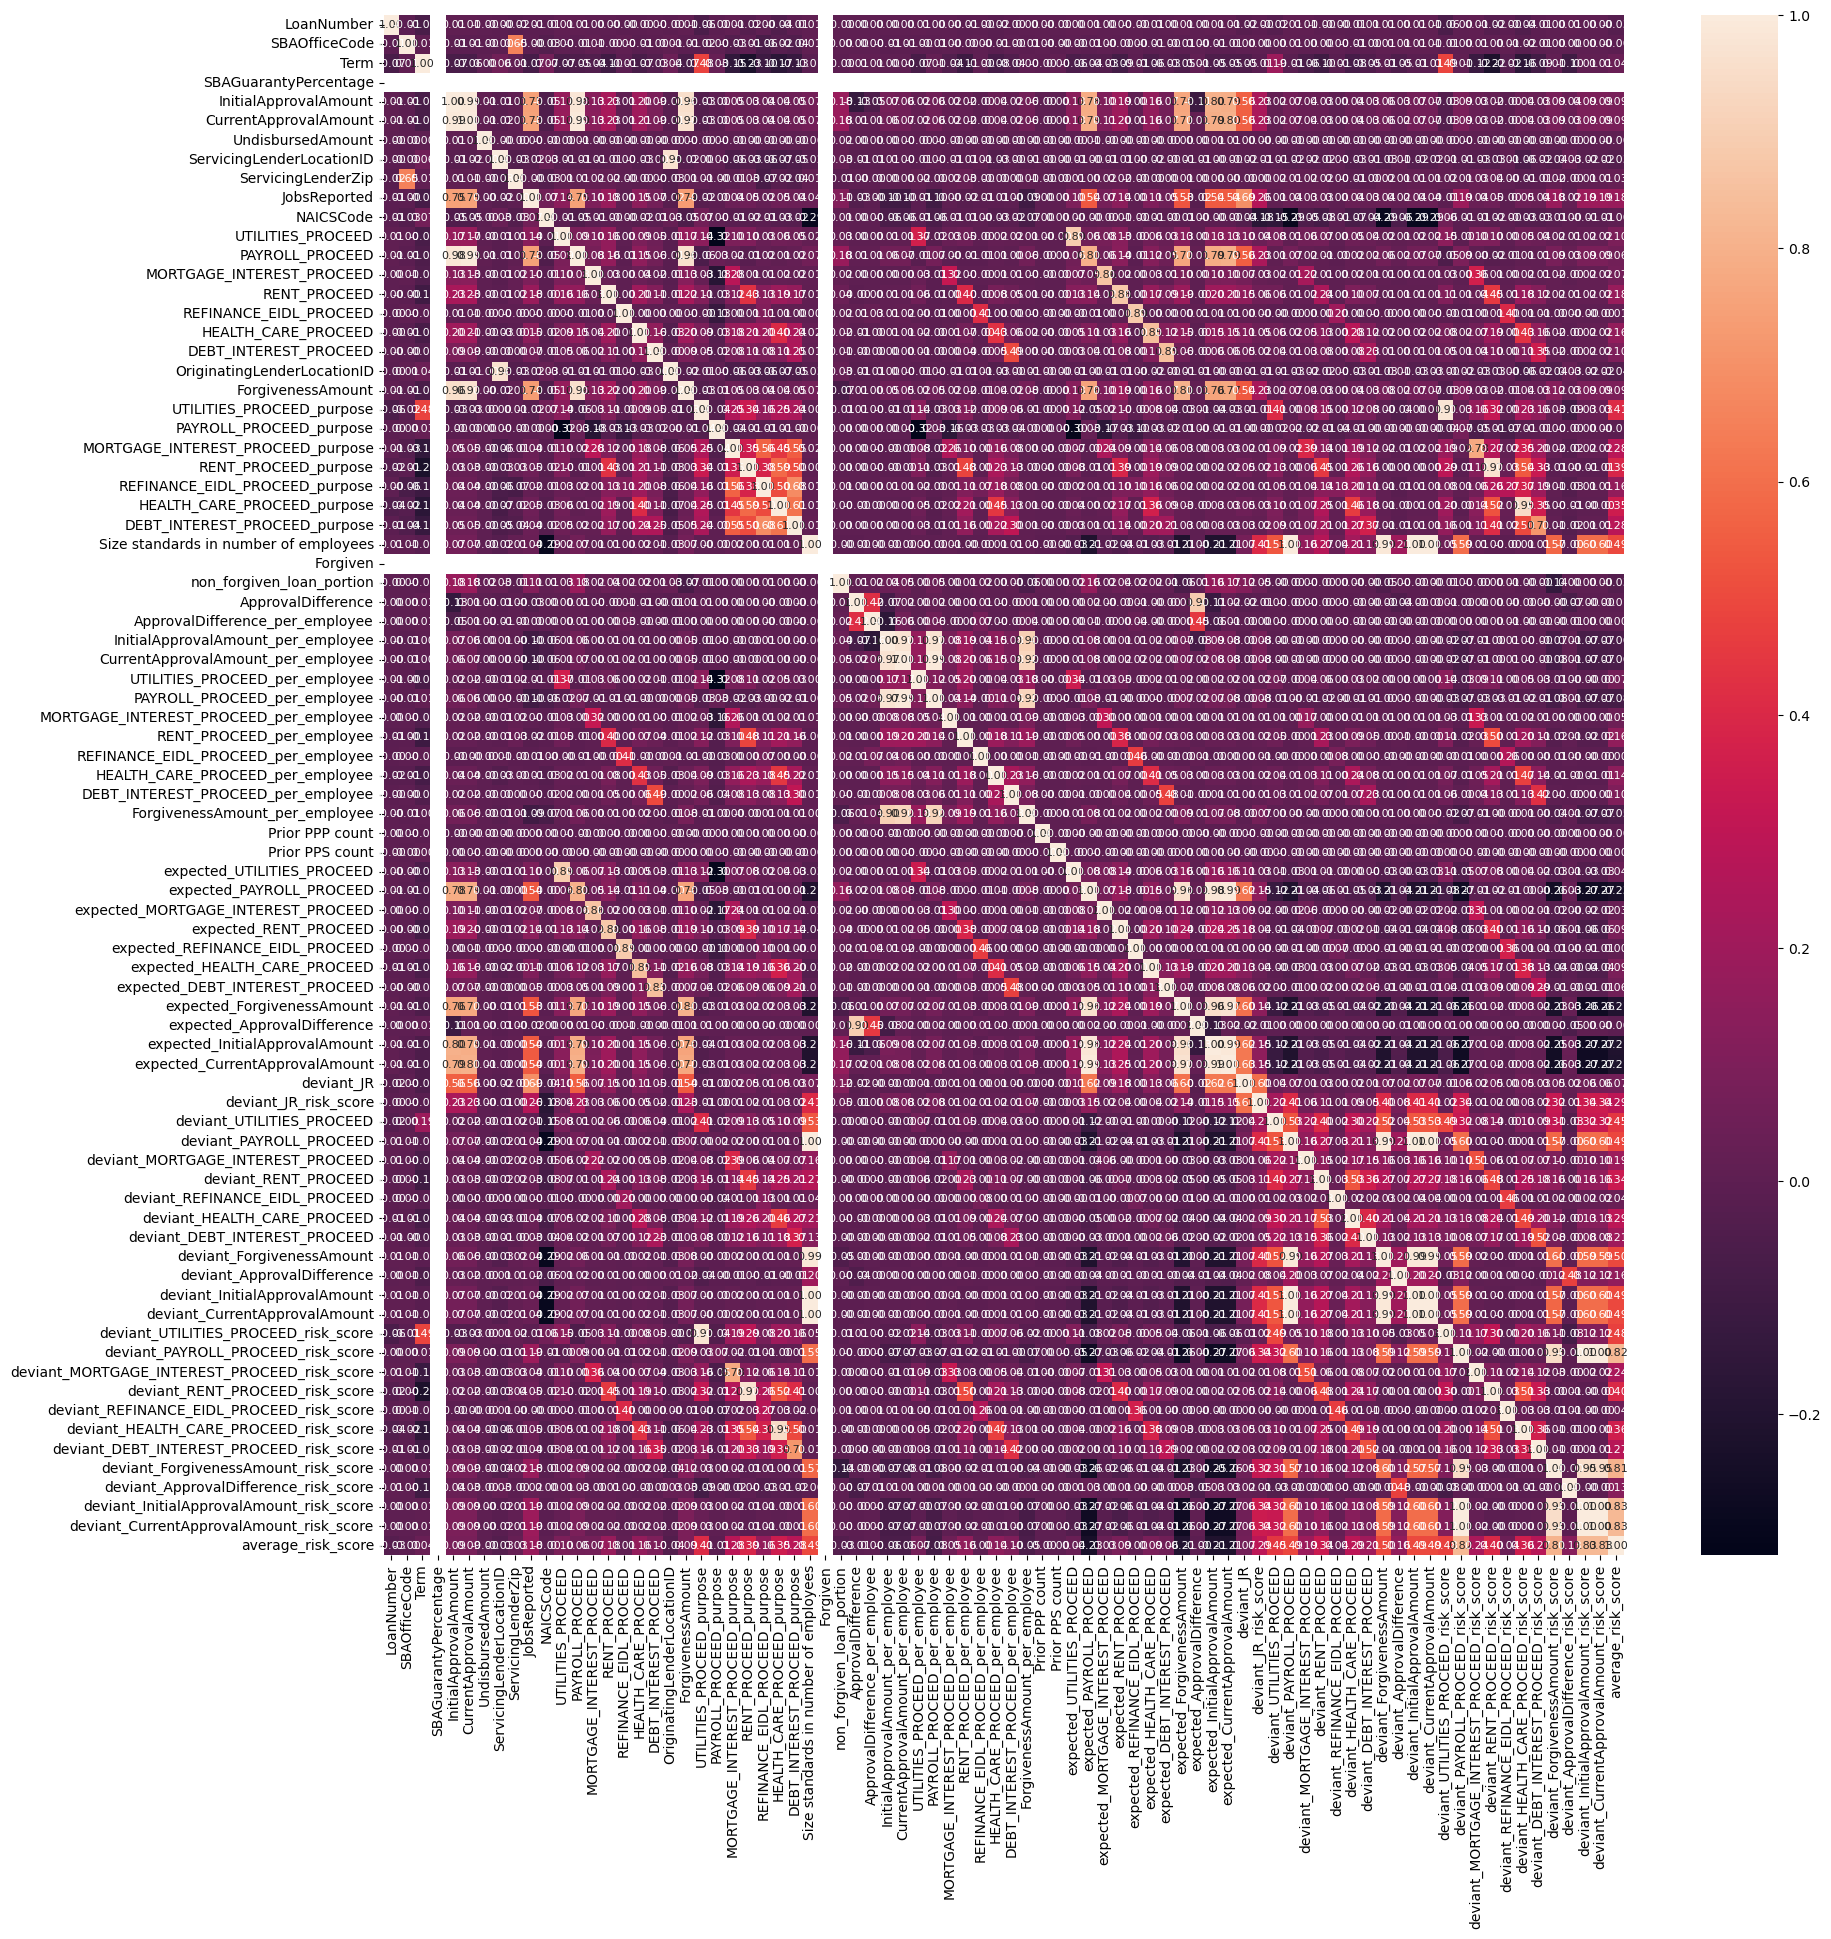

In [44]:
#correlation Matrix to study correlation between different variables
matrix=df.corr()
f,ax=plt.subplots(figsize=(20,20))
sns.heatmap(matrix, annot=True, annot_kws={"size": 8}, fmt=".2f")

    - Initial and Current Approval Amount were both highly correlated with ForgivenessAmount, indicating both in a statistical sense the higher the approval amount, the higher the forgiveness amount but logically of the loans that were forgiven, it would seem that they were mostly, if not completely forgiven, rather than just partially.
    
    - Initial and Current Approval Amount were both highly correlated with PAYROLL_PROCEED, indicating that most loans were used to process Payroll rather than utilities, mortgage interest, rent, EIDL refinancing, healthcare, or debt interest. Ranked by correlation: payroll, rent, healthcare, mortgage interest, debt interest, EIDL refinance.
    
    - Initial and Current Approval amount were highly correlated with JobsReported, indicating that the SBA and lenders generally approved higher loan amounts for businesses that reported more jobs.

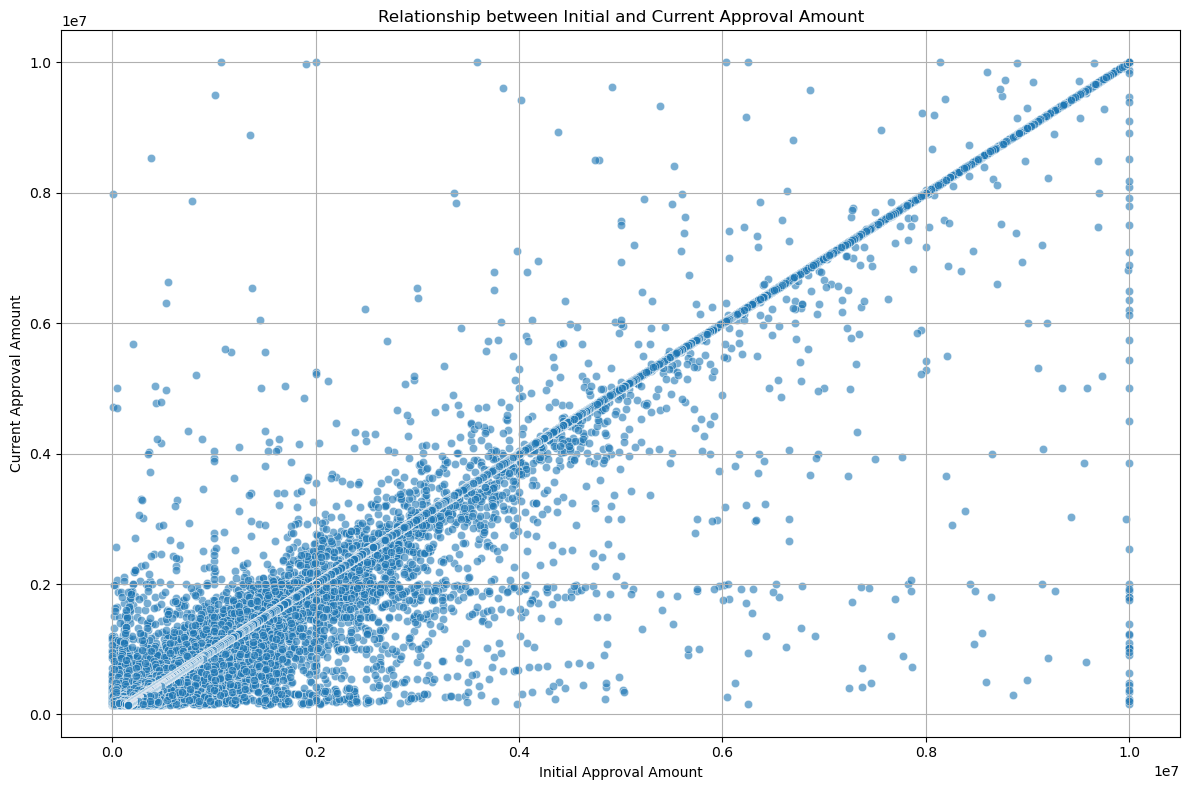

In [45]:
# Relationship between Initial and Current Approval Amount
plt.figure(figsize=(12,8))
sns.scatterplot(x=df['InitialApprovalAmount'], y=df['CurrentApprovalAmount'], alpha=0.6)
plt.title('Relationship between Initial and Current Approval Amount')
plt.xlabel('Initial Approval Amount')
plt.ylabel('Current Approval Amount')
plt.grid(True)
plt.tight_layout()

# Avoid scientific notation on the x and y axes
ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.yaxis.set_major_formatter(ScalarFormatter())

plt.show()


In [46]:
# Outlier analysis
def detect_outliers(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    return data[(data < lower_bound) | (data > upper_bound)]

initial_outliers = detect_outliers(df['InitialApprovalAmount'])
current_outliers = detect_outliers(df['CurrentApprovalAmount'])

print(f"Number of outliers in Initial Approval Amount: {len(initial_outliers)}")
print(f"Number of outliers in Current Approval Amount: {len(current_outliers)}")

Number of outliers in Initial Approval Amount: 101545
Number of outliers in Current Approval Amount: 101366


#### Filter the companies where the CurrentApprovalAmount is less than 80% of the InitialApprovalAmount

In [47]:
# Step 1: Filter the companies
threshold = 0.7
significant_reduction_df = df[df['CurrentApprovalAmount'] < threshold * df['InitialApprovalAmount']]

significant_reduction_df.BorrowerName.nunique()
# Display these companies
#print(significant_reduction_df[['BorrowerName', 'InitialApprovalAmount', 'CurrentApprovalAmount']])


3461

In [48]:
# Grouping by NAICSCode and counting unique companies
naics_counts = significant_reduction_df.groupby('NAICSCode')['BorrowerName'].nunique()

# Filtering NAICS codes with count > 5
naics_counts = naics_counts[naics_counts >= 15]

# Displaying the NAICS codes and their respective counts
naics_counts.sort_values(ascending=False)


NAICSCode
621111.00    147
722511.00    116
541110.00     80
236220.00     68
621610.00     67
621210.00     61
721110.00     58
238220.00     54
813110.00     51
238210.00     45
541511.00     37
453998.00     36
441110.00     36
611110.00     35
238990.00     35
541330.00     34
541611.00     33
236115.00     33
484121.00     29
484110.00     29
236118.00     29
541512.00     28
722513.00     28
561320.00     28
524210.00     28
541990.00     27
0.00          27
561311.00     25
561730.00     23
541613.00     22
561110.00     21
541618.00     20
621399.00     19
999990.00     19
531210.00     19
238910.00     18
541519.00     18
621999.00     17
531120.00     17
561720.00     16
531311.00     16
812112.00     15
238140.00     15
Name: BorrowerName, dtype: int64

In [49]:
# read naics file for industry description
naics = pd.read_csv('Small_Business_Administration__SBA__Size_Standards_Table.csv')
# Grouping by NAICSCode and counting unique companies
naics_counts = significant_reduction_df.groupby('NAICSCode')['BorrowerName'].nunique().reset_index()

# Filtering NAICS codes with count > 15
naics_counts = naics_counts[naics_counts['BorrowerName'] >= 15]

# Merge with the 'naics' DataFrame to get the corresponding NAICS Industry Description
naics_counts = naics_counts.merge(naics[['NAICS Codes', 'NAICS Industry Description']], left_on='NAICSCode', right_on='NAICS Codes', how='left')

# Select only the desired columns
naics_counts = naics_counts[['NAICSCode', 'BorrowerName', 'NAICS Industry Description']]

# Displaying the NAICS codes, their respective counts, and the matching NAICS Industry Description
naics_counts = naics_counts.sort_values(by='BorrowerName', ascending=False)
naics_counts


NAICSCode  BorrowerName                         NAICS Industry Description
32  621111.00           147  Offices of Physicians (except Mental Health Sp...
38  722511.00           116                           Full-Service Restaurants
17  541110.00            80                                 Offices of Lawyers
3   236220.00            68  Commercial and Institutional Building Construc...
35  621610.00            67                          Home Health Care Services
33  621210.00            61                                Offices of Dentists
37  721110.00            58           Hotels (except Casino Hotels) and Motels
6   238220.00            54  Plumbing, Heating, and Air‑Conditioning Contra...
41  813110.00            51                            Religious Organizations
5   238210.00            45  Electrical Contractors and Other Wiring Instal...
19  541511.00            37               Custom Computer Programming Services
10  453998.00            36  All Other Miscellaneous Store Retailers (excep...
9   441110.00            36                                    New Car Dealers
31  611110.00            35                   Elementary and Secondary Schools
8   238990.00            35              All Other Specialty Trade Contractors
18  541330.00            34                               Engineering Services
22  541611.00            33  Administrative Management and General Manageme...
1   236115.00            33  New Single-family Housing Construction (Except...
12  484121.00            29  General Freight Trucking, Long‑Distance, Truck...
11  484110.00            29                    General Freight Trucking, Local
2   236118.00            29                             Residential Remodelers
20  541512.00            28                   Computer Systems Design Services
39  722513.00            28                        Limited-Service Restaurants
28  561320.00            28                            Temporary Help Services
13  524210.00            28                  Insurance Agencies and Brokerages
25  541990.00            27  All Other Professional, Scientific and Technic...
0        0.00            27                                                NaN
27  561311.00            25                      Employment Placement Agencies
30  561730.00            23                               Landscaping Services
23  541613.00            22                      Marketing Consulting Services
26  561110.00            21                     Office Administrative Services
24  541618.00            20               Other Management Consulting Services
34  621399.00            19  Offices of All Other Miscellaneous Health Prac...
42  999990.00            19                                                NaN
15  531210.00            19        Offices of Real Estate Agents and Brokers10
7   238910.00            18                       Site Preparation Contractors
21  541519.00            18                    Other Computer Related Services
36  621999.00            17  All Other Miscellaneous Ambulatory Health Care...
14  531120.00            17  Lessors of Nonresidential Buildings (except Mi...
29  561720.00            16                                Janitorial Services
16  531311.00            16                      Residential Property Managers
40  812112.00            15                                      Beauty Salons
4   238140.00            15                                Masonry Contractors

In [50]:
significant_reduction_df.head()

LoanNumber DateApproved  SBAOfficeCode ProcessingMethod  \
118  9224977406   2020-05-19           1084              PPP   
204  5527377010   2020-04-05           1084              PPP   
494  5529597010   2020-04-05           1084              PPP   
541  6263257009   2020-04-06           1084              PPP   
688  5509297006   2020-04-05           1084              PPP   

                      BorrowerName                    BorrowerAddress  \
118               NANA WORLEY, LLC  3700 CENTERPOINT DRIVE, 7TH FLOOR   
204  BERING SEA ENVIRONMENTAL, LLC              3601 C ST STE 1000-31   
494                      BSET, LLC              3601 C ST STE 1000-36   
541           AA PAIN CLINIC, INC.        4100 LAKE OTIS PKWY STE 216   
688               TDX QUALITY, LLC              3601 C ST STE 1000-21   

    BorrowerCity BorrowerState BorrowerZip LoanStatusDate    LoanStatus  Term  \
118    ANCHORAGE            AK       99503     2021-04-08  PAID IN FULL    24   
204    ANCHORAGE            AK       99503     2021-09-28  PAID IN FULL    59   
494    ANCHORAGE            AK       99503     2021-09-28  PAID IN FULL    59   
541    ANCHORAGE            AK       99508     2021-03-19  PAID IN FULL    24   
688    ANCHORAGE            AK       99503     2021-08-20  PAID IN FULL    24   

     SBAGuarantyPercentage  InitialApprovalAmount  CurrentApprovalAmount  \
118                    100             5385310.00             1850000.00   
204                    100             2239400.00             1285422.00   
494                    100              985900.00              650139.00   
541                    100              902000.00              605992.65   
688                    100              896200.00              506952.00   

     UndisbursedAmount      FranchiseName  ServicingLenderLocationID  \
118               0.00  UNKNOWN/NOTSTATED                       3386   
204               0.00  UNKNOWN/NOTSTATED                     116975   
494               0.00  UNKNOWN/NOTSTATED                     116975   
541               0.00  UNKNOWN/NOTSTATED                     116975   
688               0.00  UNKNOWN/NOTSTATED                     116975   

            ServicingLenderName ServicingLenderAddress ServicingLenderCity  \
118  FIRST NATIONAL BANK ALASKA         101 W 36TH AVE           ANCHORAGE   
204               NORTHRIM BANK            3111 'C' ST           ANCHORAGE   
494               NORTHRIM BANK            3111 'C' ST           ANCHORAGE   
541               NORTHRIM BANK            3111 'C' ST           ANCHORAGE   
688               NORTHRIM BANK            3111 'C' ST           ANCHORAGE   

    ServicingLenderState  ServicingLenderZip RuralUrbanIndicator  \
118                   AK               99503                   U   
204                   AK               99503                   U   
494                   AK               99503                   U   
541                   AK               99503                   U   
688                   AK               99503                   U   

    HubzoneIndicator LMIIndicator             BusinessAgeDescription  \
118                N            Y  EXISTING OR MORE THAN 2 YEARS OLD   
204                Y            Y  EXISTING OR MORE THAN 2 YEARS OLD   
494                Y            Y  EXISTING OR MORE THAN 2 YEARS OLD   
541                N            N  EXISTING OR MORE THAN 2 YEARS OLD   
688                Y            Y  EXISTING OR MORE THAN 2 YEARS OLD   

    ProjectCity ProjectCountyName ProjectState ProjectZip   CD  JobsReported  \
118   ANCHORAGE         ANCHORAGE           AK      99503  AK-        231.00   
204   ANCHORAGE         ANCHORAGE           AK      99503  AK-        159.00   
494   ANCHORAGE         ANCHORAGE           AK      99503  AK-         73.00   
541   ANCHORAGE         ANCHORAGE           AK      99508  AK-         47.00   
688   ANCHORAGE         ANCHORAGE           AK      99503  AK-         57.00   

     NAICSCo

In [51]:
significant_reduction_df['average_risk_score'].mean()

0.2814668593048798

In [52]:
# Filtering companies with NAICSCode as 0 or "0.00"
companies_with_naics_zero = significant_reduction_df[significant_reduction_df['NAICSCode'].isin([0, "0.00"])]

# Displaying these companies
companies_with_naics_zero['BorrowerName']

72495                                         EHT FPSJ, LLC
82133                     HEALTHCARE MANAGEMENT SYSTEMS INC
133083                                             B K MILL
136632                         J & J BUILDING COMPANY, INC.
142010                                 JAY GROSSMAN DDS INC
251689                  COMMERCIAL RENOVATION SERVICES, INC
252928                                MARTIN CONSULTING INC
265458                                     M9 SOLUTIONS LLC
281626                                    FAMILY THRIFT INC
318153    PRINCETON REHABILITATION AND HEALTH CARE CENTE...
334365                            RAM FUND, INC. DBA BOYDEN
348534     CANOPY SPECIALTY INSURANCE LLC-SBA SMALL 7A TERM
460533                                        THE PAC GROUP
462120    V.O.I.C.E. INC. OF MICHIGAN, DBA VALLEY ORGANI...
478276                 MONARCH HEALTHCARE OPERATING VII LLC
579168                                BEVERLY FREIGHT, INC.
625081           VCC, INC. DBA CICERO CO

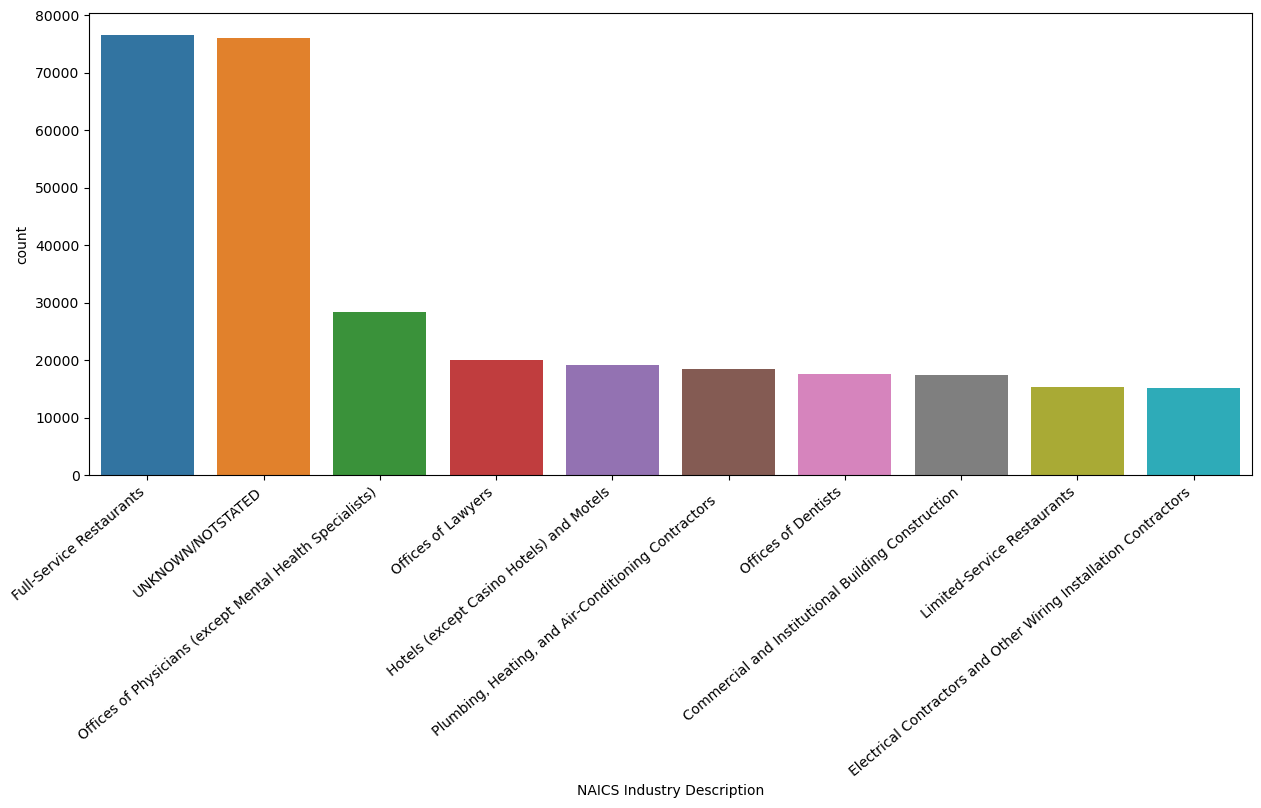

In [53]:
# loan application counts by industry
plt.figure(figsize=(15,6))  #this creates an 8 inch wide, 4 inch high

ax=sns.countplot(x="NAICS Industry Description", data=df,
                 order=df['NAICS Industry Description'].value_counts().iloc[:10].index)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.show()

### PPP vs PPS counts

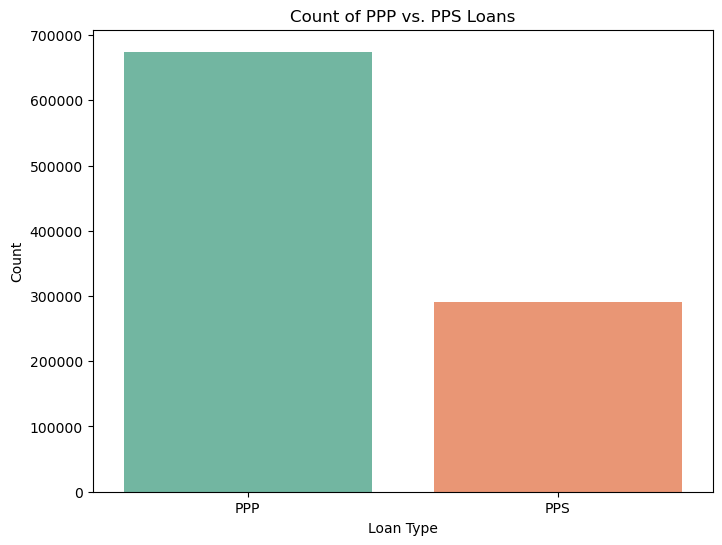

In [54]:
import seaborn as sns
import matplotlib.pyplot as plt

# Count the number of PPP and PPS loans
loan_counts = df['ProcessingMethod'].value_counts()

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x=loan_counts.index, y=loan_counts.values, palette="Set2")
plt.title('Count of PPP vs. PPS Loans')
plt.xlabel('Loan Type')
plt.ylabel('Count')

plt.show()

### Loans By State

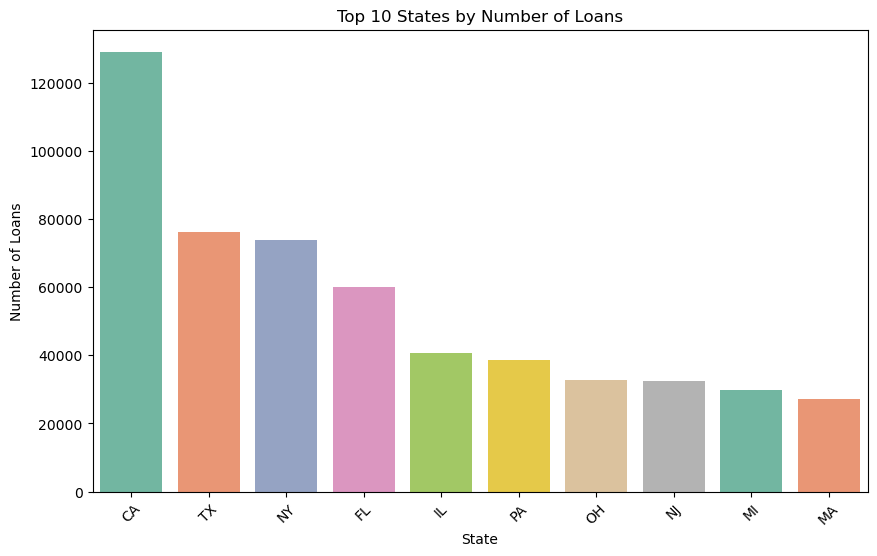

In [55]:
# Group the DataFrame by 'BorrowerState' and count the number of loans, then select the top 10 states
top_states = df.groupby('BorrowerState')['LoanNumber'].count().nlargest(10)

# Create a bar plot using Seaborn
plt.figure(figsize=(10, 6))
sns.barplot(x=top_states.index, y=top_states.values, palette="Set2")
plt.xlabel('State')
plt.ylabel('Number of Loans')
plt.title('Top 10 States by Number of Loans')
plt.xticks(rotation=45)
plt.show()

### PPP vs PPS loans tenures

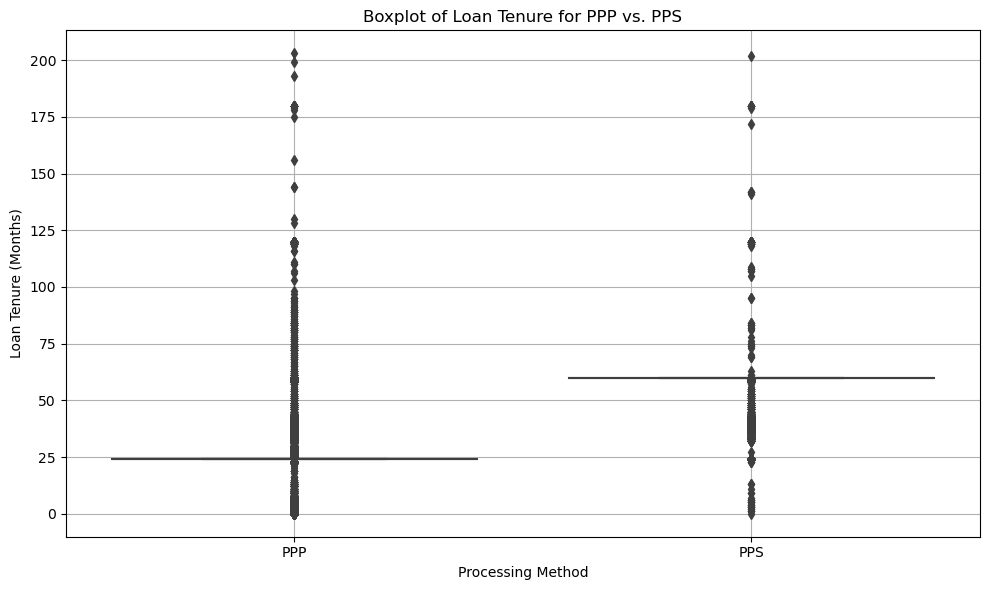

In [56]:
# Filter data for PPP and PPS loans
ppp_data = df[df['ProcessingMethod'] == 'PPP']['Term']
pps_data = df[df['ProcessingMethod'] == 'PPS']['Term']

# Boxplot
plt.figure(figsize=(10,6))
sns.boxplot(x=df['ProcessingMethod'], y=df['Term'])
plt.title('Boxplot of Loan Tenure for PPP vs. PPS')
plt.xlabel('Processing Method')
plt.ylabel('Loan Tenure (Months)')
plt.grid(True)
plt.tight_layout()
plt.show()

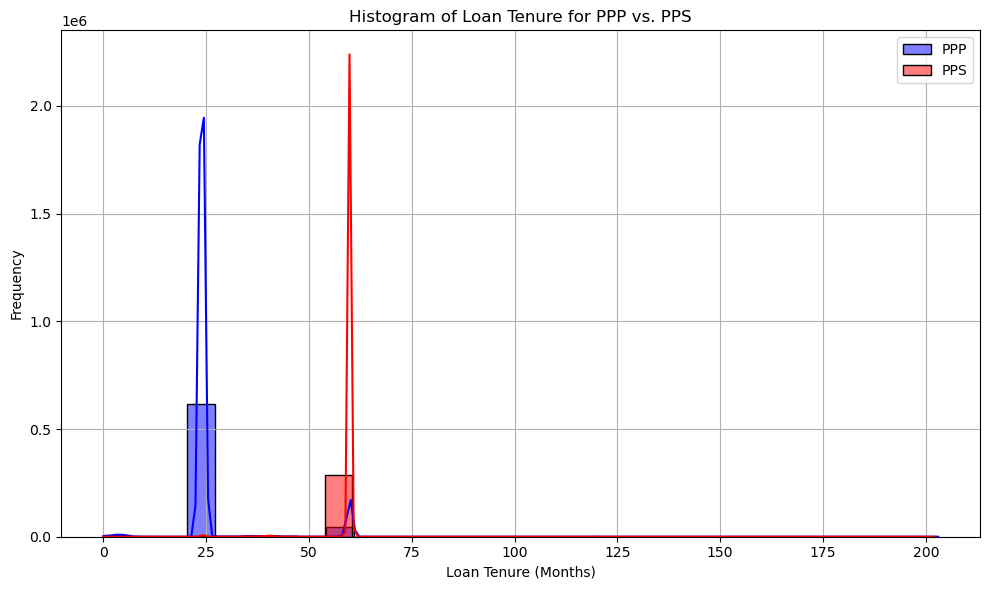

In [57]:
# Histogram
plt.figure(figsize=(10,6))
sns.histplot(ppp_data, bins=30, kde=True, label='PPP', color='blue', alpha=0.5)
sns.histplot(pps_data, bins=30, kde=True, label='PPS', color='red', alpha=0.5)
plt.title('Histogram of Loan Tenure for PPP vs. PPS')
plt.xlabel('Loan Tenure (Months)')
plt.ylabel('Frequency')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [58]:
# Total amount borrowed for PPP and PPS
ppp_total_amount = df[df['ProcessingMethod'] == 'PPP']['CurrentApprovalAmount'].sum()
pps_total_amount = df[df['ProcessingMethod'] == 'PPS']['CurrentApprovalAmount'].sum()

# Convert date columns to datetime objects
df['DateApproved'] = pd.to_datetime(df['DateApproved'])

# Split the DataFrame into PPP and PPS
ppp_df = df[df['ProcessingMethod'] == 'PPP']
pps_df = df[df['ProcessingMethod'] == 'PPS']

# Group by 'BorrowerName' and get the date for each method
ppp_dates = ppp_df.groupby('BorrowerName')['DateApproved'].first()
pps_dates = pps_df.groupby('BorrowerName')['DateApproved'].first()

# Calculate the time difference in days
time_difference = (pps_dates - ppp_dates).dt.days.dropna()
average_time_difference = time_difference.mean()

print(f"Total amount borrowed for PPP: ${ppp_total_amount}")
print(f"Total amount borrowed for PPS: ${pps_total_amount}")
print(f"Average time between borrowing PPP and PPS: {average_time_difference} days")


Total amount borrowed for PPP: $384943225732.42993
Total amount borrowed for PPS: $126763059491.39998
Average time between borrowing PPP and PPS: 301.676490091319 days


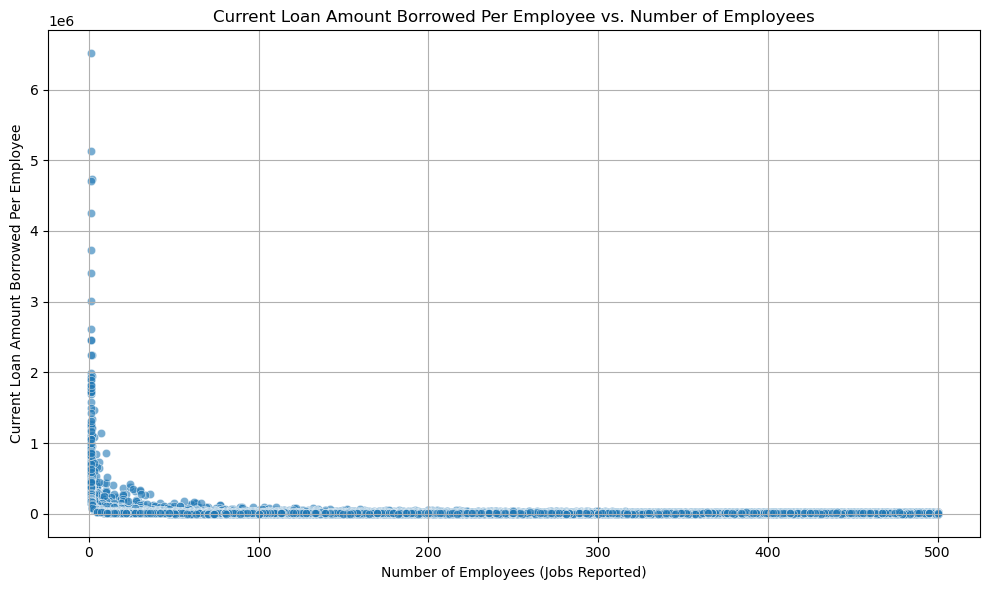

In [59]:
# Calculate the loan amount per employee
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='JobsReported', y='CurrentApprovalAmount_per_employee', alpha=0.6)
plt.title('Current Loan Amount Borrowed Per Employee vs. Number of Employees')
plt.xlabel('Number of Employees (Jobs Reported)')
plt.ylabel('Current Loan Amount Borrowed Per Employee')
plt.grid(True)
plt.tight_layout()
plt.show()

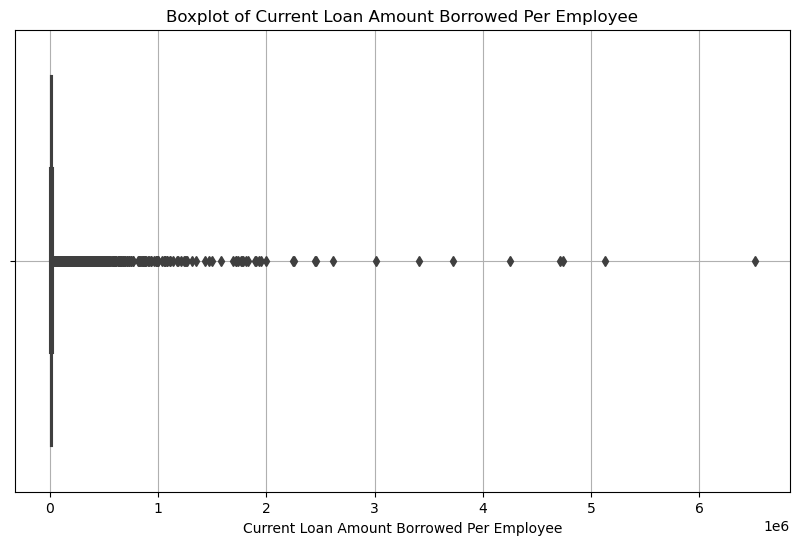

In [60]:
# boxplot of current loan amount borrowed per employee
plt.figure(figsize=(10,6))
sns.boxplot(df['CurrentApprovalAmount_per_employee'])
plt.title('Boxplot of Current Loan Amount Borrowed Per Employee')
plt.xlabel('Current Loan Amount Borrowed Per Employee')
plt.grid(True)
plt.show()

In [119]:
# Filter companies with CurrentApprovalAmount_per_employee > 1,000,000
high_loan_companies = df[df['CurrentApprovalAmount_per_employee'] > 1000000]

# Display details of these companies, including ForgivenessAmount
high_loan_companies[['BorrowerName', 'CurrentApprovalAmount', 'JobsReported', 'CurrentApprovalAmount_per_employee', 'PAYROLL_PROCEED','BorrowerState', 'BorrowerCity', 'average_risk_score']]


BorrowerName  CurrentApprovalAmount  \
13841         C & L ELECTRIC COOPERATIVE CORPORATION             1576200.00   
36036                                   BMD SERVICES             4499787.00   
36075                     MOXIE MANAGEMENT GROUP LLC             4398500.00   
38346              PACIFIC SHORES MEDICAL GROUP INC.             2250900.00   
39914                               PREMIER REPUBLIC             1995000.00   
41171                     ST. JOHN BOSCO HIGH SCHOOL             1775187.00   
41236                              NAVIGATOR SCHOOLS             1765000.00   
41665            CHILDREN'S COUNCIL OF SAN FRANCISCO             1692891.00   
46576                                     QUANTIFIND             1180080.00   
48434                                    INCLIN, INC             1061600.00   
122552                      ST. MARGARET MARY SCHOOL              223364.00   
201242                              47TH AND 7TH LLC             7986873.00   
266147                  GODS ANOINTED YOUTH MINISTRY             1253112.00   
266773                        CALVARY BAPTIST TEMPLE             1037700.00   
304103                 IDAHO ARTS CHARTER SCHOOL INC             1082300.00   
373874                           NAZARETH HOME, INC.             3013797.00   
374499                     LINK ELECTRIC COMPANY LLC             1241000.00   
374608                    JUSTICE AV SOLUTIONS, INC.             1107900.00   
383185                  JENA BAND OF CHOCTAW INDIANS             2460000.00   
384069           CARMICHAEL'S CASHWAY PHARMACY, INC.             1246682.07   
397190               DELTA MANAGEMENT ASSOCIATES INC             2451475.00   
397677             J. P. NOONAN TRANSPORTATION, INC.             1907930.00   
521885              SOUTHLAND TRANSPORTATION COMPANY             2425980.00   
522602                  HEALY WHOLESALE COMPANY INC.             1498000.00   
522935             INDUSTRIAL BATTERY & CHARGER INC.             1269600.00   
547522                     TREGO/DUGAN AVIATION, INC             4247700.00   
547554                BADLANDS TANK LINE, TEXAS, LLC             3251740.00   
548743                  RELIANT TRANSPORTATION, INC.              594600.00   
558666                                 MOLDCABLE INC             3726400.00   
559190                              TRI-B INDUSTRIES             2220425.00   
603716                                SH GROUP, INC.             9480024.00   
603885                         PREMIER CARE STAFFING             6512997.50   
604451                          2201 COLLINS FEE LLC             3900200.00   
607386  PARK AVENUE BUILDING & ROOFING SUPPLIES, LLC             1815522.00   
607673                             LEVER CAPITAL LLC             1739460.00   
612134          CAPACITY INTERACTIVE CONSULTING, LLC             1060900.00   
678909                            APEX EXPRESS, INC.             1933600.00   
710160                        MILLER TRUCK LINES LLC             3408380.45   
733658                   PENNROSE MANAGEMENT COMPANY             5131282.00   
733699                   B. J. BALDWIN ELECTRIC, INC             4711700.00   
734259                      RAMSIS HOLDINGS LLC. DBA             2692792.00   
735505                        ERNEST D. MENOLD, INC.             1723370.00   
761171                             VINCERA REHAB LLC              212300.00   
779065                          ARCH ENTERPRISES LLC             1716500.00   
779438   KENNETH SHULER'S SCHOOL OF COSMETOLOGY INC.             1177300.00   
809448    EN SU CASA PRIMARY HOME CARE SERVICE, INC.             2620000.00   
811090                                 JAMES A. BRAY             1896600.00   
811464                             DEAVRA A DAUGHTRY             1779400.00   
812924                     SV RELIABLE TRANSPORT LLC             1430015.00   
813633                                      CLW, INC             1309903.50   
895650     

In [117]:
"{:.3f}".format(high_loan_companies['average_risk_score'].mean())

'0.240'

In [118]:
"{:.3f}".format(df['average_risk_score'].mean())

'0.228'

In [71]:
"{:.3f}".format(high_loan_companies['average_risk_score'].median())

'0.277'

In [72]:
"{:.3f}".format(df['average_risk_score'].median())

'0.230'

These high loan companies with over $2m current approval amount per employee have higher average risk scores than the average for all loans.

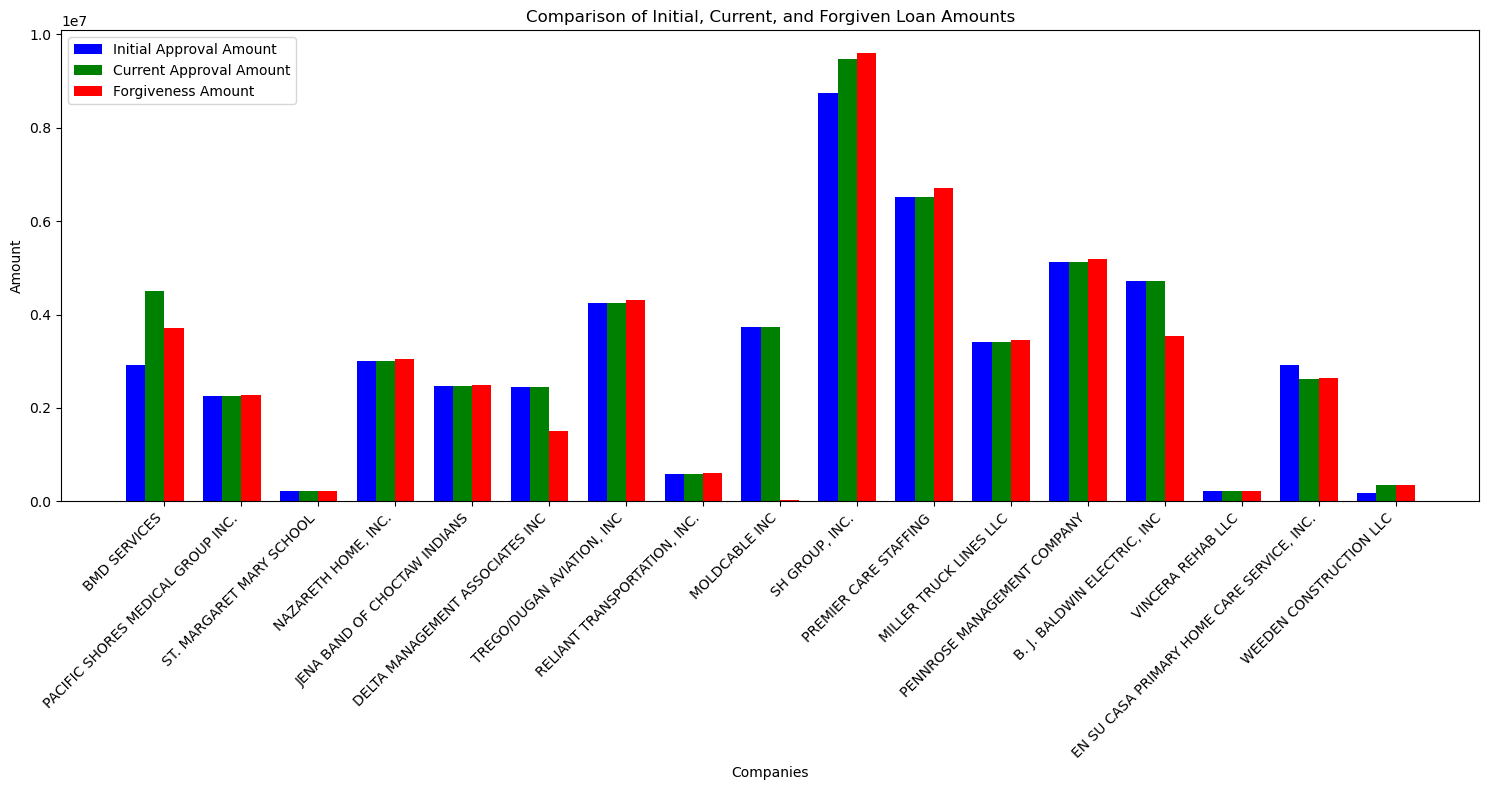

In [79]:
# Filter companies with CurrentApprovalAmount_per_employee > 2,000,000
high_loan_companies = df[df['CurrentApprovalAmount_per_employee'] > 2000000]

# Create a separate dataframe with relevant columns
loan_details_df = high_loan_companies[['BorrowerName', 'InitialApprovalAmount', 'CurrentApprovalAmount', 'ForgivenessAmount']]

# Set the positions and width for the bars
positions = list(range(len(loan_details_df['BorrowerName'])))
width = 0.25

# Plotting
fig, ax = plt.subplots(figsize=(15, 8))

# Create bars for InitialApprovalAmount, CurrentApprovalAmount, and ForgivenessAmount
plt.bar(positions, loan_details_df['InitialApprovalAmount'], width=width, label='Initial Approval Amount', color='blue', align='center')
plt.bar([p+width for p in positions], loan_details_df['CurrentApprovalAmount'], width=width, label='Current Approval Amount', color='green', align='center')
plt.bar([p+width*2 for p in positions], loan_details_df['ForgivenessAmount'], width=width, label='Forgiveness Amount', color='red', align='center')

# Setting the x-axis labels to be the company names
ax.set_xticks([p + 1.5*width for p in positions])
ax.set_xticklabels(loan_details_df['BorrowerName'], rotation=45, ha='right')

# Adding title, legend, and labels
plt.title('Comparison of Initial, Current, and Forgiven Loan Amounts')
plt.xlabel('Companies')
plt.ylabel('Amount')
plt.legend(loc='upper left')

# Display the plot
plt.tight_layout()
plt.show()


In [86]:
# Grouping by ProcessingMethod and summing the ForgivenessAmount
forgiveness_by_method = df.groupby('ProcessingMethod')['ForgivenessAmount'].sum()

print(forgiveness_by_method)

ProcessingMethod
PPP   371896353689.07
PPS   124025608096.82
Name: ForgivenessAmount, dtype: float64


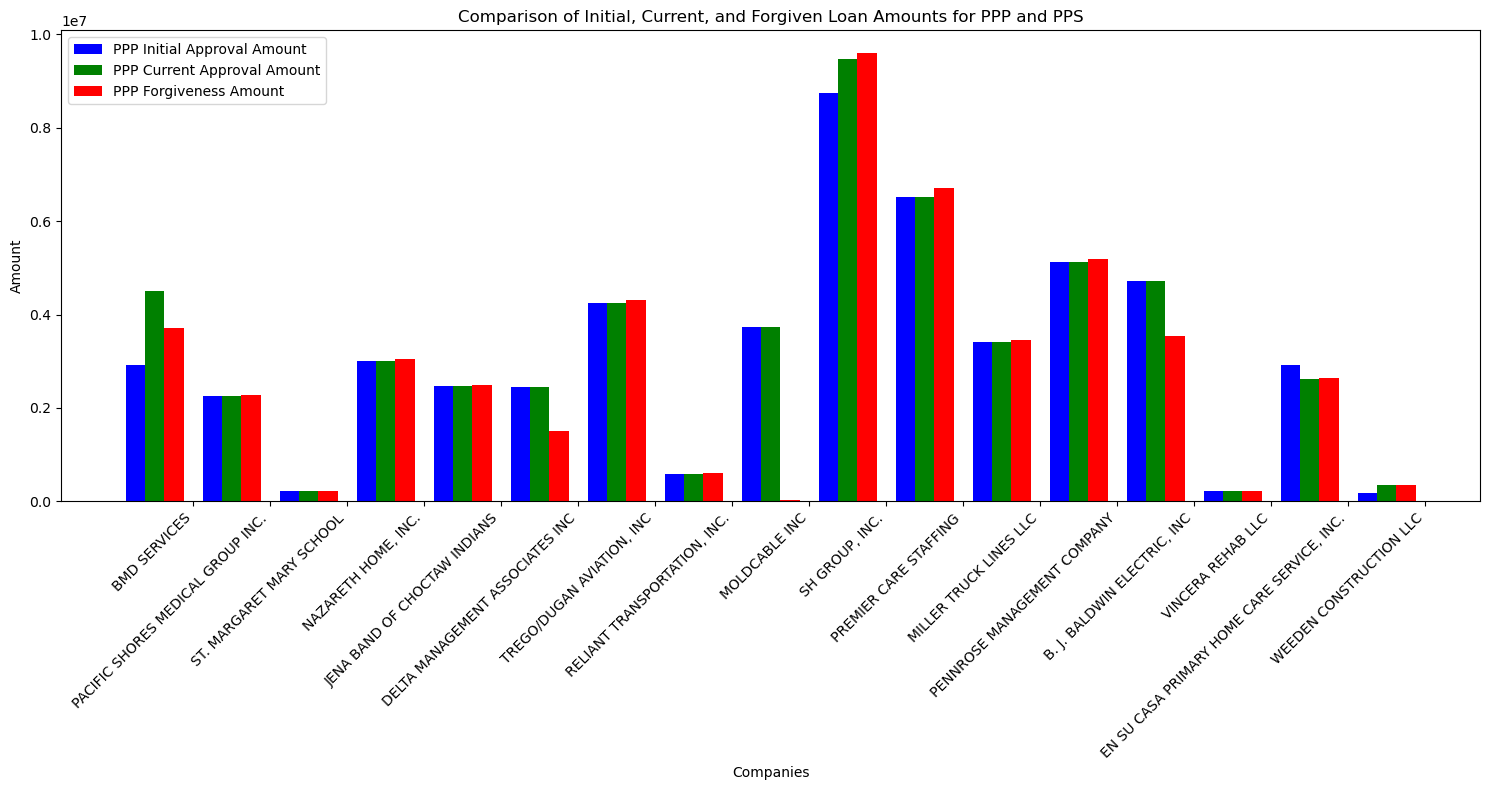

In [87]:
import matplotlib.pyplot as plt
import numpy as np

# Filter dataframes for PPP and PPS
ppp_df = loan_details_df[df['ProcessingMethod'] == 'PPP']
pps_df = loan_details_df[df['ProcessingMethod'] == 'PPS']

# Set positions and width for bars
positions = list(range(len(loan_details_df['BorrowerName'])))
width = 0.25

fig, ax = plt.subplots(figsize=(15, 8))

# Bars for PPP
plt.bar(positions, ppp_df['InitialApprovalAmount'], width=width, label='PPP Initial Approval Amount', color='blue', align='center')
plt.bar([p+width for p in positions], ppp_df['CurrentApprovalAmount'], width=width, label='PPP Current Approval Amount', color='green', align='center')
plt.bar([p+width*2 for p in positions], ppp_df['ForgivenessAmount'], width=width, label='PPP Forgiveness Amount', color='red', align='center')

# Bars for PPS (adjusting the positions for visualization) only if there are PPS entries
if not pps_df.empty:
    plt.bar([p+width*3 for p in positions], pps_df['InitialApprovalAmount'], width=width, label='PPS Initial Approval Amount', color='cyan', align='center')
    plt.bar([p+width*4 for p in positions], pps_df['CurrentApprovalAmount'], width=width, label='PPS Current Approval Amount', color='lime', align='center')
    plt.bar([p+width*5 for p in positions], pps_df['ForgivenessAmount'], width=width, label='PPS Forgiveness Amount', color='magenta', align='center')

# Setting x-axis labels to company names
ax.set_xticks([p + 3*width for p in positions])
ax.set_xticklabels(loan_details_df['BorrowerName'], rotation=45, ha='right')

# Adding title, legend, and labels
plt.title('Comparison of Initial, Current, and Forgiven Loan Amounts for PPP and PPS')
plt.xlabel('Companies')
plt.ylabel('Amount')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()

None of these companies applied for PPS (2nd loan amount)
Why do some of them have higher forgiveness amount thand approval amounts?

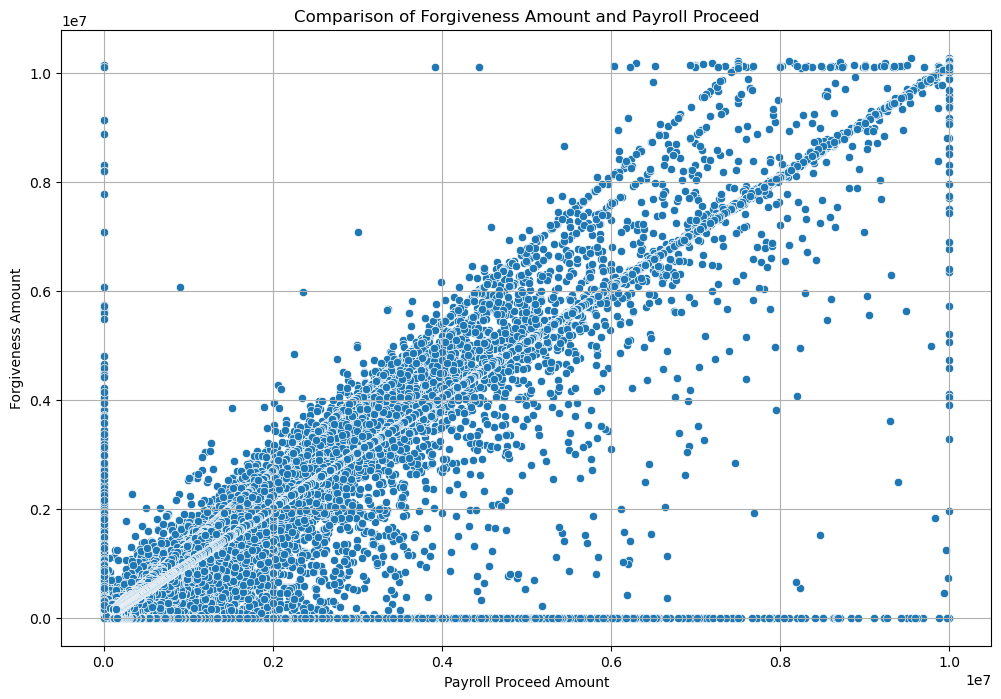

In [88]:
plt.figure(figsize=(12, 8))

sns.scatterplot(data=df, x='PAYROLL_PROCEED', y='ForgivenessAmount')

plt.title('Comparison of Forgiveness Amount and Payroll Proceed')
plt.xlabel('Payroll Proceed Amount')
plt.ylabel('Forgiveness Amount')
plt.grid(True)
plt.show()

In [89]:
correlation = df['PAYROLL_PROCEED'].corr(df['ForgivenessAmount'])
print(f"Correlation between Forgiveness Amount and Payroll Proceed: {correlation:.2f}")

Correlation between Forgiveness Amount and Payroll Proceed: 0.96


In [90]:
# Filter dataset for PPP and PPS
ppp_data = df[df['ProcessingMethod'] == 'PPP']
pps_data = df[df['ProcessingMethod'] == 'PPS']

# Get top 5 lenders for PPP
top_ppp_lenders = ppp_data['ServicingLenderName'].value_counts().head(5)
print(top_ppp_lenders)

JPMORGAN CHASE BANK, NATIONAL ASSOCIATION    40548
BANK OF AMERICA, NATIONAL ASSOCIATION        30213
PNC BANK, NATIONAL ASSOCIATION               18772
TRUIST BANK                                  15988
WELLS FARGO BANK, NATIONAL ASSOCIATION       12571
Name: ServicingLenderName, dtype: int64


In [91]:
# Get top 5 lenders for PPS
top_pps_lenders = pps_data['ServicingLenderName'].value_counts().head(5)
print(top_pps_lenders)

JPMORGAN CHASE BANK, NATIONAL ASSOCIATION    16673
BANK OF AMERICA, NATIONAL ASSOCIATION        10046
LOAN SOURCE INCORPORATED                      8492
PNC BANK, NATIONAL ASSOCIATION                6688
MANUFACTURERS AND TRADERS TRUST COMPANY       5409
Name: ServicingLenderName, dtype: int64


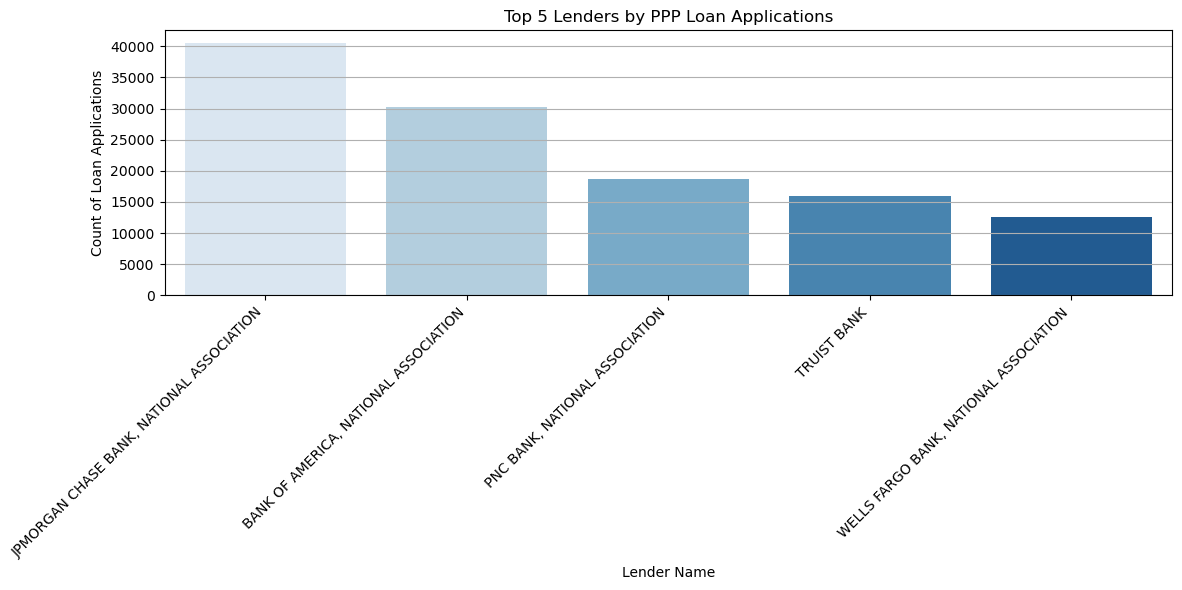

In [92]:
plt.figure(figsize=(12, 6))

sns.barplot(x=top_ppp_lenders.index, y=top_ppp_lenders, palette='Blues')
plt.title('Top 5 Lenders by PPP Loan Applications')
plt.xlabel('Lender Name')
plt.ylabel('Count of Loan Applications')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

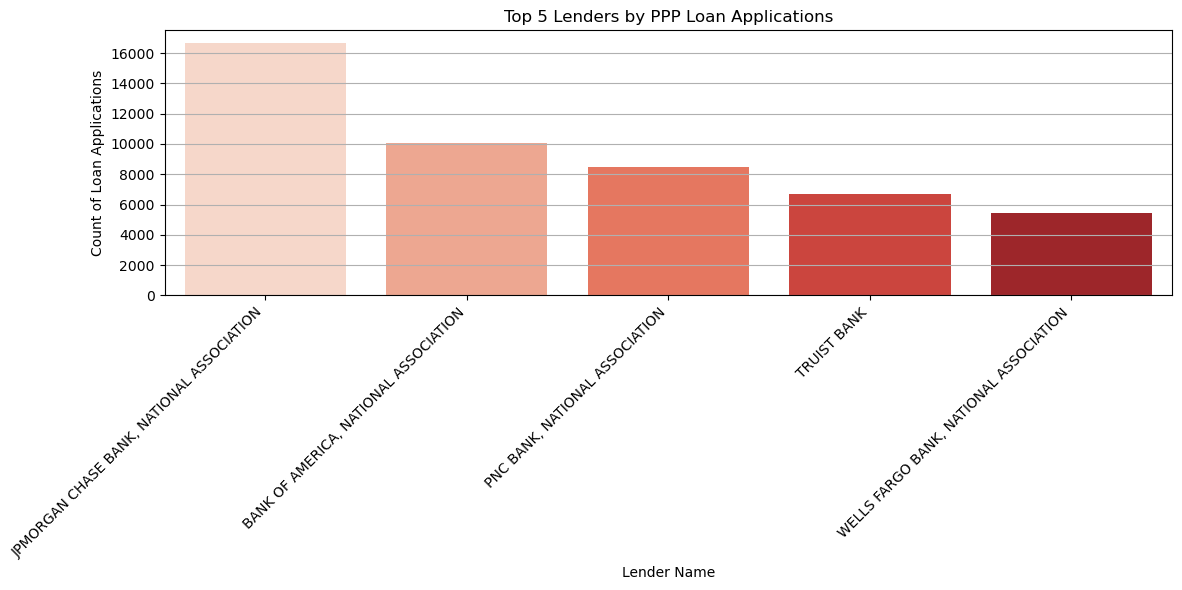

In [93]:
plt.figure(figsize=(12, 6))

sns.barplot(x=top_ppp_lenders.index, y=top_pps_lenders, palette='Reds')
plt.title('Top 5 Lenders by PPP Loan Applications')
plt.xlabel('Lender Name')
plt.ylabel('Count of Loan Applications')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [96]:
# Filter under processing method
filtered_df = df[df['ProcessingMethod'].isin(['PPP', 'PPS'])]

# Group based on 'BorrowerName', 'BorrowerAddress', and 'ProcessingMethod'
grouped = filtered_df.groupby(['BorrowerName', 'BorrowerAddress', 'ProcessingMethod']).size().reset_index(name='Count')

# Pivot to get 'PPP Count' and 'PPS Count' as columns
pivot_table = grouped.pivot_table(index=['BorrowerName', 'BorrowerAddress'], columns='ProcessingMethod', values='Count', fill_value=0).reset_index()

# Display in decending order under ppp
pivot_table.sort_values(by='PPP', ascending=False).head()

ProcessingMethod                                       BorrowerName  \
783085                           STUDENT ALTERNATIVES PROGRAM, INC.   
735193                         SHAKOPEE MDEWAKANTON SIOUX COMMUNITY   
356666            GUSTAVO GARCIA-SILLER ARCHBISHOP OF SAN ANTONI...   
365335                 HARRELSON UTILITY REPAIR AND CONTRACTING INC   
155006               CATHOLIC CHARITIES OF THE DIOCESE OF ROCHESTER   

ProcessingMethod          BorrowerAddress  PPP  PPS  
783085                  707 LINDBERG AVE.    4    0  
735193              2400 MYSTIC LAKE BLVD    3    0  
356666                2718 W WOODLAWN AVE    3    0  
365335            1310 OLD US HIGHWAY 264    3    0  
155006                 94 EXCHANGE STREET    3    0

In [100]:
grouped.head()

BorrowerName  \
0  "A" BEST INTERNATIONAL PLACEMENT SERVICES, LLC   
1                          "C" GROUP CONCEPTS LLC   
2                          "C" GROUP CONCEPTS LLC   
3                       # 1 HOME CARE AGENCY CORP   
4                             # 1 TOP SCHOOL, LLC   

                     BorrowerAddress ProcessingMethod  Count  
0           4325 N. 23RD ST.. STE. E              PPP      1  
1                  1207 N WALKER AVE              PPP      1  
2                  1207 N WALKER AVE              PPS      1  
3  10200 E GIRARD AVE BLDG A STE 105              PPP      1  
4        2704 OLD ROSEBUD RD STE 130              PPP      1

In [102]:
# Splitting dataframes for PPP and PPS
df_ppp = df[df['ProcessingMethod'] == 'PPP'].set_index('BorrowerName')
df_pps = df[df['ProcessingMethod'] == 'PPS'].set_index('BorrowerName')

# Finding the difference in reported jobs for companies that appear in both
common_companies = df_ppp.index.intersection(df_pps.index)
job_difference = df_ppp.loc[common_companies, 'JobsReported'] - df_pps.loc[common_companies, 'JobsReported']

# Extract companies with significant differences
significant_diff_companies = job_difference[job_difference.abs() > 75]

# Using the main dataframe to get industry descriptions
industry_df = df[df['BorrowerName'].isin(significant_diff_companies.index)]

# Grouping by "NAICS Industry Description" and counting unique companies
industry_counts = industry_df.groupby('NAICS Industry Description').agg({
    'BorrowerName': 'nunique'
}).rename(columns={'BorrowerName': 'Number of Companies'})

# Displaying the results in a tabular format sorted by the number of companies
industry_counts_sorted = industry_counts.sort_values(by='Number of Companies', ascending=False)
display(industry_counts_sorted)

Number of Companies
NAICS Industry Description                                             
Full-Service Restaurants                                            677
UNKNOWN/NOTSTATED                                                   471
Hotels (except Casino Hotels) and Motels                            265
Limited-Service Restaurants                                         159
Fitness and Recreational Sports Centers                             111
Employment Placement Agencies                                        96
Commercial and Institutional Building Construction                   88
Home Health Care Services                                            86
Temporary Help Services                                              86
Religious Organizations                                              72
Electrical Contractors and Other Wiring Install...                   71
All Other Specialty Trade Contractors                                65
Civic and Social Organizations                                       59
Recreational and Vacation Camps (except Campgro...                   56
Plumbing, Heating, and Air‑Conditioning Contrac...                   56
Elementary and Secondary Schools                                     51
All Other Amusement and Recreation Industries                        50
Offices of Physicians (except Mental Health Spe...                   47
Other Individual and Family Services                                 46
Drinking Places (Alcoholic Beverages)                                46
All Other Professional, Scientific and Technica...                   45
Administrative Management and General Managemen...                   42
Child Care Services                                                  42
Engineering Services                                                 39
Janitorial Services                                                  38
Caterers                                                             36
Security Guards and Patrol Services                                  36
Office Administrative Services                                       35
Colleges, Universities and Professional Schools                      34
All Other Personal Services                                          34
New Car Dealers                                                      34
Food Service Contractors                                             33
Computer Systems Design Services                                     32
Nursing Care Facilities (Skilled Nursing Facili...                   31
Offices of Other Holding Companies                                   31
Highway, Street, and Bridge Construction                             28
New Single-family Housing Construction (Except ...                   28
Theater Companies and Dinner Theaters                                27
Child and Youth Services                                             27
Golf Courses and Country Clubs                                       26
Beauty Salons                                                        26
All Other Miscellaneous Schools and Instruction                      26
Support Activities for Oil and Gas Operations                        26
Residential Remodelers                                               25
Services for the Elderly and Persons with Disab...                   25
Educational Support Services                                         24
Other Management Consulting Services                                 23
Museums                                                              23
All Other Business Support Services                                  23
Custom Computer Programming Services                                 23
Sports and Recreation Instruction                                    22
Drywall and Insulation Contractors                                   21
Other Heavy and Civil Engineering Construction                       20
Amusement and Theme Parks                                            20
Other Activities Rel

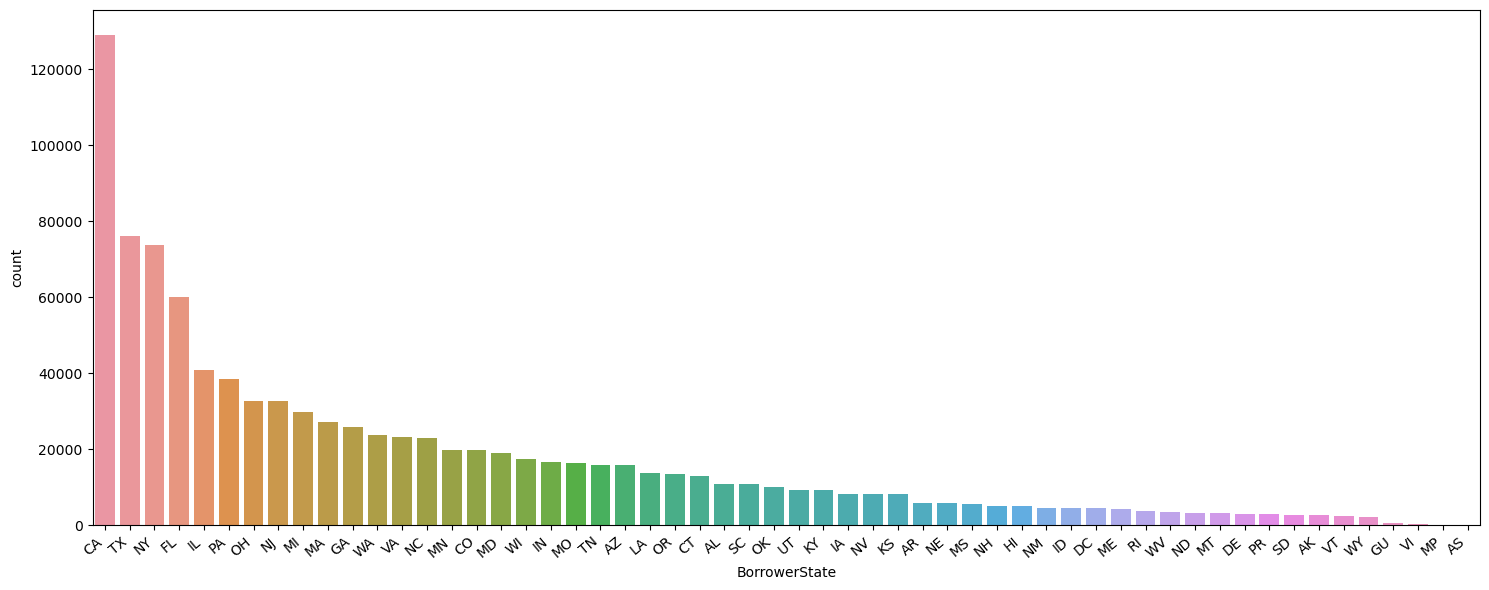

In [103]:
# create a countplot
plt.figure(figsize=(15,6)) 
ax=sns.countplot(x="BorrowerState", data=df, order=df['BorrowerState'].value_counts().iloc[:56].index)

ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")

plt.tight_layout()
plt.show()

In [104]:
# create a dictionary to map state abbreviations to full names
state_dict = {'AL': 'Alabama', 'AK': 'Alaska', 'AZ': 'Arizona', 'AR': 'Arkansas', 'CA': 'California', 'CO': 'Colorado', 'CT': 'Connecticut', 'DE': 'Delaware', 'FL': 'Florida', 'GA': 'Georgia', 'HI': 'Hawaii', 'ID': 'Idaho', 'IL': 'Illinois', 'IN': 'Indiana', 'IA': 'Iowa', 'KS': 'Kansas', 'KY': 'Kentucky', 'LA': 'Louisiana', 'ME': 'Maine', 'MD': 'Maryland', 'MA': 'Massachusetts', 'MI': 'Michigan', 'MN': 'Minnesota', 'MS': 'Mississippi', 'MO': 'Missouri', 'MT': 'Montana', 'NE': 'Nebraska', 'NV': 'Nevada', 'NH': 'New Hampshire', 'NJ': 'New Jersey', 'NM': 'New Mexico', 'NY': 'New York', 'NC': 'North Carolina', 'ND': 'North Dakota', 'OH': 'Ohio', 'OK': 'Oklahoma', 'OR': 'Oregon', 'PA': 'Pennsylvania', 'RI': 'Rhode Island', 'SC': 'South Carolina', 'SD': 'South Dakota', 'TN': 'Tennessee', 'TX': 'Texas', 'UT': 'Utah', 'VT': 'Vermont', 'VA': 'Virginia', 'WA': 'Washington', 'WV': 'West Virginia', 'WI': 'Wisconsin', 'WY': 'Wyoming'}


# create a new column with full state names
df['state_name'] = df['BorrowerState'].map(state_dict)

# display the updated DataFrame
df.head()

LoanNumber DateApproved  SBAOfficeCode ProcessingMethod  \
0  9547507704   2020-05-01            464              PPP   
1  9777677704   2020-05-01            464              PPP   
2  5791407702   2020-05-01           1013              PPP   
3  6223567700   2020-05-01            920              PPP   
4  9662437702   2020-05-01            101              PPP   

               BorrowerName        BorrowerAddress       BorrowerCity  \
0     SUMTER COATINGS, INC.  2410 HIGHWAY 15 SOUTH             SUMTER   
1     PLEASANT PLACES, INC.    7684 SOUTHRAIL ROAD   NORTH CHARLESTON   
2   BOYER CHILDREN'S CLINIC       1850 BOYER AVE E            SEATTLE   
3  KIRTLEY CONSTRUCTION INC   1661 MARTIN RANCH RD     SAN BERNARDINO   
4              AERO BOX LLC      UNKNOWN/NOTSTATED  UNKNOWN/NOTSTATED   

       BorrowerState BorrowerZip LoanStatusDate    LoanStatus  Term  \
0  UNKNOWN/NOTSTATED       29150     2020-12-18  PAID IN FULL    24   
1  UNKNOWN/NOTSTATED       29420     2021-09-28  PAID IN FULL    24   
2  UNKNOWN/NOTSTATED       98112     2021-03-17  PAID IN FULL    24   
3  UNKNOWN/NOTSTATED       92407     2021-10-16  PAID IN FULL    24   
4  UNKNOWN/NOTSTATED       UNKNO     2021-08-17  PAID IN FULL    24   

   SBAGuarantyPercentage  InitialApprovalAmount  CurrentApprovalAmount  \
0                    100              769358.78              769358.78   
1                    100              736927.79              736927.79   
2                    100              691355.00              691355.00   
3                    100              499871.00              499871.00   
4                    100              367437.00              367437.00   

   UndisbursedAmount      FranchiseName  ServicingLenderLocationID  \
0               0.00  UNKNOWN/NOTSTATED                      19248   
1               0.00  UNKNOWN/NOTSTATED                      19248   
2               0.00  UNKNOWN/NOTSTATED                       9551   
3               0.00  UNKNOWN/NOTSTATED                       9551   
4               0.00  UNKNOWN/NOTSTATED                      57328   

                     ServicingLenderName   ServicingLenderAddress  \
0                           SYNOVUS BANK            1148 BROADWAY   
1                           SYNOVUS BANK            1148 BROADWAY   
2  BANK OF AMERICA, NATIONAL ASSOCIATION  100 N TRYON ST, STE 170   
3  BANK OF AMERICA, NATIONAL ASSOCIATION  100 N TRYON ST, STE 170   
4           THE HUNTINGTON NATIONAL BANK            17 S HIGH ST.   

  ServicingLenderCity ServicingLenderState  ServicingLenderZip  \
0            COLUMBUS                   GA               31901   
1            COLUMBUS                   GA               31901   
2           CHARLOTTE                   NC               28202   
3           CHARLOTTE                   NC               28202   
4            COLUMBUS                   OH               43215   

  RuralUrbanIndicator HubzoneIndicator LMIIndicator  \
0                   U                N            N   
1                   U                Y            Y   
2                   U                N            N   
3                   U                N            N   
4                   U                N            N   

              BusinessAgeDescription        ProjectCity  ProjectCountyName  \
0  EXISTING OR MORE THAN 2 YEARS OLD             SUMTER             SUMTER   
1  EXISTING OR MORE THAN 2 YEARS OLD   NORTH CHARLESTON         CHARLESTON   
2    NEW BUSINESS OR 2 YEARS OR LESS            SEATTLE               KING   
3    NEW BUSINESS OR 2 YEARS OR LESS     SAN BERNARDINO     SAN BERNARDINO   
4                  UNKNOWN/NOTSTATED  UNKNOWN/NOTSTATED  UNKNOWN/NOTSTATED   

        ProjectState ProjectZip                 CD  JobsReported  NAICSCode  \
0                 SC      29150              SC-05         62.00  325510.00   
1                 SC      29420              SC-06         73.00  561730.00   
2                 WA      98112              WA-0

In [105]:
# count the unique values in column_1
borrowerstatecounts = df['BorrowerState'].value_counts()

# create a new DataFrame with the counts
borrowerstatecounts_df = pd.DataFrame({'unique_values': borrowerstatecounts.index, 'count': borrowerstatecounts.values})

borrowerstatecounts_df['state_name'] = borrowerstatecounts_df['unique_values'].map(state_dict)

# display the new DataFrame
borrowerstatecounts_df

unique_values   count      state_name
0                  CA  129085      California
1                  TX   76061           Texas
2                  NY   73819        New York
3                  FL   60002         Florida
4                  IL   40763        Illinois
5                  PA   38500    Pennsylvania
6                  OH   32639            Ohio
7                  NJ   32515      New Jersey
8                  MI   29791        Michigan
9                  MA   27179   Massachusetts
10                 GA   25787         Georgia
11                 WA   23619      Washington
12                 VA   23224        Virginia
13                 NC   22796  North Carolina
14                 MN   19720       Minnesota
15                 CO   19669        Colorado
16                 MD   18955        Maryland
17                 WI   17346       Wisconsin
18                 IN   16594         Indiana
19                 MO   16339        Missouri
20                 TN   15864       Tennessee
21                 AZ   15757         Arizona
22                 LA   13669       Louisiana
23                 OR   13403          Oregon
24                 CT   12882     Connecticut
25                 AL   10912         Alabama
26                 SC   10739  South Carolina
27                 OK    9995        Oklahoma
28                 UT    9258            Utah
29                 KY    9178        Kentucky
30                 IA    8295            Iowa
31                 NV    8254          Nevada
32                 KS    8201          Kansas
33                 AR    5857        Arkansas
34                 NE    5804        Nebraska
35                 MS    5504     Mississippi
36                 NH    5069   New Hampshire
37                 HI    4979          Hawaii
38                 NM    4482      New Mexico
39                 ID    4415           Idaho
40                 DC    4383             NaN
41                 ME    4185           Maine
42                 RI    3786    Rhode Island
43                 WV    3365   West Virginia
44                 ND    3222    North Dakota
45                 MT    3142         Montana
46                 DE    2990        Delaware
47                 PR    2952             NaN
48                 SD    2695    South Dakota
49                 AK    2662          Alaska
50                 VT    2265         Vermont
51                 WY    2137         Wyoming
52                 GU     443             NaN
53                 VI     290             NaN
54                 MP      82             NaN
55                 AS      20             NaN
56  UNKNOWN/NOTSTATED      13             NaN

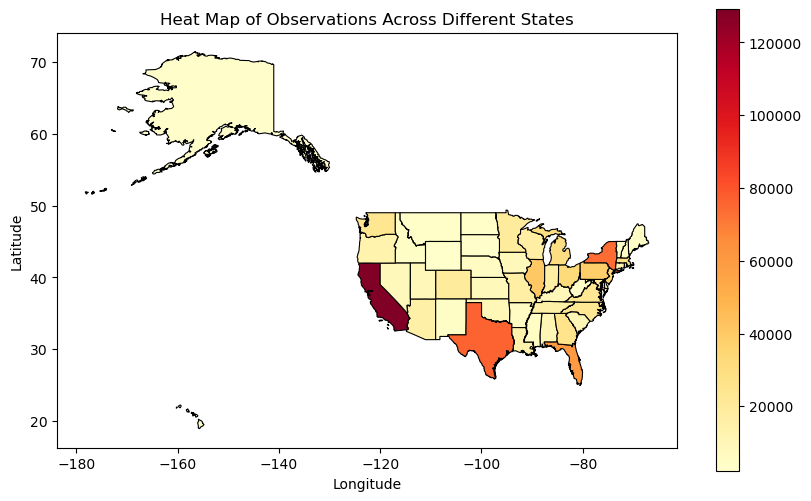

In [107]:
#graph showing loan applications per state across the United States
import geopandas as gpd

# load data from a csv file
#data = pd.read_csv('data.csv')

# load shapefile data of the USA
usa = gpd.read_file('geo_export_f042980c-ca77-4dd6-bff4-38d915a31cce.shp')

# merge the data and shapefile data based on the state column
merged = usa.set_index('state_name').join(borrowerstatecounts_df.set_index('state_name'))

# create a choropleth map
fig, ax = plt.subplots(figsize=(10, 6))
merged.plot(column='count', cmap='YlOrRd', linewidth=0.8, edgecolor='black', ax=ax, legend=True)

# set the axis labels and title
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Heat Map of Observations Across Different States')

# display the plot
plt.show()

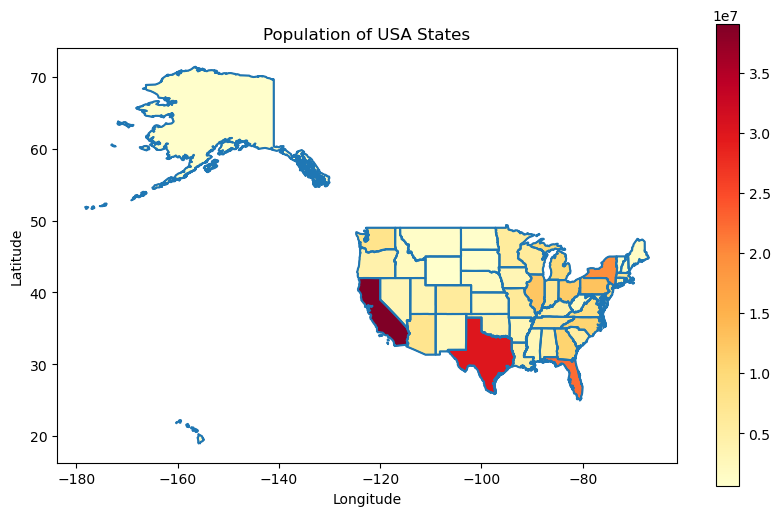

In [108]:
#create the population map

# Load the shapefile
fp = "geo_export_f042980c-ca77-4dd6-bff4-38d915a31cce.shp"
gdf = gpd.read_file(fp)

# Example population data in a dictionary
# Note: Use actual population data for accurate visualization
population_data = {
    'California': 39029342,
    'Texas': 30029572,
    'Florida': 22244823,
    'New York': 19677151,
    'Pennsylvania': 12972008,
    'Illinois': 12582032,
    'Ohio': 11756058,
    'Georgia': 10912876,
    'North Carolina': 10698973,
    'Michigan': 10034113,
    'New Jersey': 9261699,
    'Virginia': 8683619,
    'Washington': 7785786,
    'Arizona': 7359197,
    'Tennessee': 7051339,
    'Massachusetts': 6981974,
    'Indiana': 6833037,
    'Missouri': 6177957,
    'Maryland': 6164660,
    'Wisconsin': 5892539,
    'Colorado': 5839926,
    'Minnesota': 5717184,
    'South Carolina': 5282634,
    'Alabama': 5074296,
    'Louisiana': 4590241,
    'Kentucky': 4512310,
    'Oregon': 4240137,
    'Oklahoma': 4019800,
    'Connecticut': 3626205,
    'Utah': 3380800,
    'Iowa': 3200517,
    'Nevada': 3177772,
    'Arkansas': 3045637,
    'Mississippi': 2940057,
    'Kansas': 2937150,
    'New Mexico': 2113344,
    'Nebraska': 1967923,
    'Idaho': 1939033,
    'West Virginia': 1775156,
    'Hawaii': 1440196,
    'New Hampshire': 1395231,
    'Maine': 1385340,
    'Montana': 1122867,
    'Rhode Island': 1093734,
    'Delaware': 1018396,
    'South Dakota': 909824,
    'North Dakota': 779261,
    'Alaska': 733583,
    'District of Columbia': 671803,
    'Vermont': 647064,
    'Wyoming': 581381
}

# Adding a new column to the GeoDataFrame for population
gdf['population'] = gdf['state_name'].map(population_data)

# Handling NaN values, if any
gdf['population'].fillna(0, inplace=True)

# Calculate population density: population/area and add it as a new column

# gdf['popdensity'] = round(gdf['population'] / gdf['geometry'].area).astype(int)

merged = gdf.set_index('state_name').join(borrowerstatecounts_df.set_index('state_name'))

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
gdf.boundary.plot(ax=ax)
merged.plot(column='population', cmap='YlOrRd', linewidth=0.8, edgecolor='black', ax=ax, legend=True)
plt.title('Population of USA States')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

In [109]:
df.head(2)

LoanNumber DateApproved  SBAOfficeCode ProcessingMethod  \
0  9547507704   2020-05-01            464              PPP   
1  9777677704   2020-05-01            464              PPP   

            BorrowerName        BorrowerAddress      BorrowerCity  \
0  SUMTER COATINGS, INC.  2410 HIGHWAY 15 SOUTH            SUMTER   
1  PLEASANT PLACES, INC.    7684 SOUTHRAIL ROAD  NORTH CHARLESTON   

       BorrowerState BorrowerZip LoanStatusDate    LoanStatus  Term  \
0  UNKNOWN/NOTSTATED       29150     2020-12-18  PAID IN FULL    24   
1  UNKNOWN/NOTSTATED       29420     2021-09-28  PAID IN FULL    24   

   SBAGuarantyPercentage  InitialApprovalAmount  CurrentApprovalAmount  \
0                    100              769358.78              769358.78   
1                    100              736927.79              736927.79   

   UndisbursedAmount      FranchiseName  ServicingLenderLocationID  \
0               0.00  UNKNOWN/NOTSTATED                      19248   
1               0.00  UNKNOWN/NOTSTATED                      19248   

  ServicingLenderName ServicingLenderAddress ServicingLenderCity  \
0        SYNOVUS BANK          1148 BROADWAY            COLUMBUS   
1        SYNOVUS BANK          1148 BROADWAY            COLUMBUS   

  ServicingLenderState  ServicingLenderZip RuralUrbanIndicator  \
0                   GA               31901                   U   
1                   GA               31901                   U   

  HubzoneIndicator LMIIndicator             BusinessAgeDescription  \
0                N            N  EXISTING OR MORE THAN 2 YEARS OLD   
1                Y            Y  EXISTING OR MORE THAN 2 YEARS OLD   

        ProjectCity ProjectCountyName ProjectState ProjectZip     CD  \
0            SUMTER            SUMTER           SC      29150  SC-05   
1  NORTH CHARLESTON        CHARLESTON           SC      29420  SC-06   

   JobsReported  NAICSCode        Race          Ethnicity  UTILITIES_PROCEED  \
0         62.00  325510.00  UNANSWERED  UNKNOWN/NOTSTATED               0.00   
1         73.00  561730.00       WHITE  UNKNOWN/NOTSTATED               0.00   

   PAYROLL_PROCEED  MORTGAGE_INTEREST_PROCEED  RENT_PROCEED  \
0        769358.78                       0.00          0.00   
1        736927.79                       0.00          0.00   

   REFINANCE_EIDL_PROCEED  HEALTH_CARE_PROCEED  DEBT_INTEREST_PROCEED  \
0                    0.00                 0.00                   0.00   
1                    0.00                 0.00                   0.00   

          BusinessType  OriginatingLenderLocationID OriginatingLender  \
0          CORPORATION                        19248      SYNOVUS BANK   
1  SOLE PROPRIETORSHIP                        19248      SYNOVUS BANK   

  OriginatingLenderCity OriginatingLenderState      Gender      Veteran  \
0              COLUMBUS                     GA  UNANSWERED   UNANSWERED   
1              COLUMBUS                     GA  MALE OWNED  NON-VETERAN   

  NonProfit  ForgivenessAmount ForgivenessDate  UTILITIES_PROCEED_purpose  \
0         N          773553.37      2020-11-20                          0   
1         N          746336.24      2021-08-12                          0   

   PAYROLL_PROCEED_purpose  MORTGAGE_INTEREST_PROCEED_purpose  \
0                        1                                  0   
1                        1                                  0   

   RENT_PROCEED_purpose  REFINANCE_EIDL_PROCEED_purpose  \
0                     0                               0   
1                     0                               0   

   HEALTH_CARE_PROCEED_purpose  DEBT_INTEREST_PROCEED_purpose  \
0                            0                              0   
1                            0                              0   

        NAICS Industry Description  Size standards in number of employees  \
0  Paint and Coating Manufacturing                                1000.00   
1             Landscaping Services                                  43.94  

In [115]:
df['state_name'] = df['state_name'].fillna(0)
df.isnull().sum()

LoanNumber                                      0
DateApproved                                    0
SBAOfficeCode                                   0
ProcessingMethod                                0
BorrowerName                                    0
BorrowerAddress                                 0
BorrowerCity                                    0
BorrowerState                                   0
BorrowerZip                                     0
LoanStatusDate                                  0
LoanStatus                                      0
Term                                            0
SBAGuarantyPercentage                           0
InitialApprovalAmount                           0
CurrentApprovalAmount                           0
UndisbursedAmount                               0
FranchiseName                                   0
ServicingLenderLocationID                       0
ServicingLenderName                             0
ServicingLenderAddress                          0


In [120]:
df.to_csv('ppp_model.csv', index = False)